### Классификация пользовательских запросов
Предлагается решить задачу с помощью модели DistilBERT

In [19]:
# базовые импорты для работы с данными
import pandas as pd
import matplotlib.pyplot as plt

# модель и токенайзер
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# для дообучения
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# препроцессинг + метрики
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from tqdm import tqdm

In [2]:
# загружаем данные
df = pd.read_csv("/kaggle/input/sb-ds-task/data.csv")

In [3]:
df.sample(10)

,text,label
6396,Можете проверить номер?,SIM-карта и номер
24925,Положил единицы на не правильный номер,Баланс
21877,не могу перевести денги с баланса ператор,Оплата
13495,"ДЛЯ ИНТЕРНЕТА""",FAQ - тарифы и услуги
1979,Настроить аппарат вручную,FAQ - интернет
25417,какие дополнительные услуги есть,Мобильные услуги
3080,"Здравствуйте, могу ли я сменить саой номер на ...",FAQ - тарифы и услуги
249,тариф,мобильная связь - тарифы
31923,услуга,Мобильные услуги
1609,Как перейти на тариф,мобильная связь - тарифы


In [4]:
# посмотреть какие лейблы вообще есть
df.label.unique()

array(['FAQ - тарифы и услуги', 'мобильная связь - тарифы',
       'Мобильный интернет', 'FAQ - интернет', 'тарифы - подбор',
       'Баланс', 'Мобильные услуги', 'Оплата', 'Личный кабинет',
       'SIM-карта и номер', 'Роуминг', 'запрос обратной связи',
       'Устройства', 'мобильная связь - зона обслуживания'], dtype=object)

In [5]:
# проверяем пустые данные
# видим что 91 пустой текст 
# и 53 лейбла с пустыми строками в качестве текста
# это всё надо будет удалить

# с лейблами всё в порядке
print(df['text'].isnull().sum())
print(df['label'].isnull().sum())
print((df['text'].str.strip() == '').sum())
print((df['label'].str.strip() == '').sum())

91
0
53
0


In [9]:
# избавляемся от пустых значений
# предположим, что при конечном использовании модели
# пустой пользовательский ввод будет каким-либо образом запрещён/ограничен
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip() != '']

In [10]:
# sanity check
print(df['text'].isnull().sum())
print((df['text'].str.strip() == '').sum())

0
0


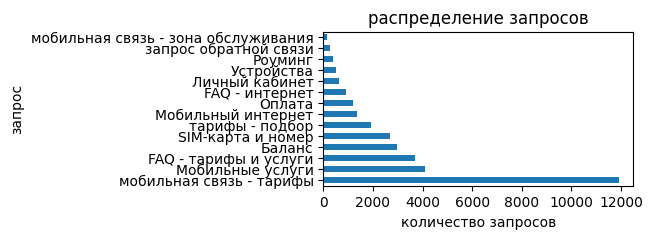

In [11]:
# проверка на всякий случай
# для понимания какие метрики потом использовать
plt.figure(figsize=(4, 2))
df['label'].value_counts().sort_values(ascending=False).plot(kind='barh')
plt.title('распределение запросов')
plt.xlabel('количество запросов')
plt.ylabel('запрос', va='center',labelpad=10)
plt.show()

In [ ]:
# label encoding как один из наиболее простых вариантов
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [13]:
# инициализируем модель и токенайзер
name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(name)
model = DistilBertForSequenceClassification.from_pretrained(name, num_labels=len(df.label.unique()))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# train/val/test сплиты + стратификация по лейблам
# 60/20/20, с 80/10/10 был оверфиттинг

train_df, tmp_df = train_test_split(df, test_size=0.4,stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df['label'],random_state=42)

In [15]:
# кастомный датасет 
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        res={}
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            return_tensors='pt',
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,)
        
        res['input_ids'] = encoding['input_ids'].flatten()
        res['attention_mask'] = encoding['attention_mask'].flatten()
        res['labels']= torch.tensor(label, dtype=torch.long)
        
        return res

In [16]:
# делим на 3 датасета
train_dataset = CustomDataset(train_df['text'].values, train_df['label'].values, tokenizer)
val_dataset = CustomDataset(val_df['text'].values, val_df['label'].values, tokenizer)
test_dataset = CustomDataset(test_df['text'].values, test_df['label'].values, tokenizer)

In [17]:
# загружаем сплиты в dataloader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [20]:
# перекидываем на gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# определяем оптимизатор и ф-ю потерь
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()

In [21]:
# основная часть -- training/eval loops
epochs = 3
train_losses = []
val_losses = []
f1_scores = []

for epoch in range(epochs):
    # обучение
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f'train epoch {epoch + 1}/{epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'train loss: {avg_train_loss}')

    # валидация
    model.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'val epoch {epoch + 1}/{epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_loss = loss_fn(logits, labels)
    val_losses.append(val_loss.item())

    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    f1_scores.append(val_f1)

    print(f'val loss: {val_loss.item()}')
    print(f'val f1-score: {val_f1}')

# тест
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


train epoch 1/3: 100%|██████████| 2450/2450 [02:25<00:00, 16.83it/s]


train loss: 1.044612952215331


val epoch 1/3: 100%|██████████| 817/817 [00:17<00:00, 47.07it/s]


val loss: 1.9061318635940552
val f1-score: 0.7630511760796989


train epoch 2/3: 100%|██████████| 2450/2450 [02:25<00:00, 16.87it/s]


train loss: 0.6738497840232995


val epoch 2/3: 100%|██████████| 817/817 [00:17<00:00, 47.10it/s]


val loss: 1.5480443239212036
val f1-score: 0.781640539975719


train epoch 3/3: 100%|██████████| 2450/2450 [02:25<00:00, 16.86it/s]


train loss: 0.5561659072347137


val epoch 3/3: 100%|██████████| 817/817 [00:17<00:00, 47.29it/s]


val loss: 1.0147523880004883
val f1-score: 0.792634402597137


testing: 100%|██████████| 817/817 [00:17<00:00, 47.12it/s]


test accuracy: 0.8032761788120024
test precision: 0.8036458103312727
test recall: 0.8032761788120024
test fi-score: 0.8003754343299809


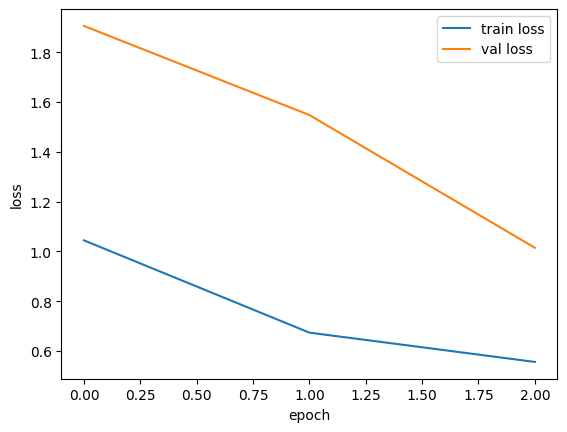

In [33]:
# accuracy для полноты картины
# но вообще классы явно (см. выше) несбалансированные, т.ч. особо в нём смысла нет

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted')
test_recall = recall_score(test_labels, test_preds, average='weighted')
test_f1 = f1_score(test_labels, test_preds, average='weighted')

print(f'test accuracy: {test_accuracy}')
print(f'test precision: {test_precision}')
print(f'test recall: {test_recall}')
print(f'test f1-score: {test_f1}')

# график для 
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [58]:
# немного собственных примеров
# в частности для одного из наименее редких классов (запрос обратной связи)
ex_questions = ['найдите тпариф', 'сколько осталось денег??',
                'Сколько стоит звонок из другой страны',
               'я уже два года жду ваш ответ!!!',
               'как узнать свой телефон']

for question in ex_questions:
    tokenized_input = tokenizer(question, return_tensors='pt')
    input_ids = tokenized_input['input_ids'].to('cuda')
    attention_mask = tokenized_input['attention_mask'].to('cuda')

    model.eval()
    with torch.no_grad():
        logits = model(input_ids, attention_mask=attention_mask).logits

    quest_label = torch.argmax(logits, dim=1).item()
    pred_class = le.classes_[quest_label]

    print(f"\nЗапрос:'{question}'\nМетка: {pred_class}")



Запрос:'найдите тпариф'
Метка: мобильная связь - тарифы

Запрос:'сколько осталось денег??'
Метка: Баланс

Запрос:'Сколько стоит звонок из другой страны'
Метка: Роуминг

Запрос:'я уже два года жду ваш ответ!!!'
Метка: запрос обратной связи

Запрос:'как узнать свой телефон'
Метка: SIM-карта и номер
